In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from skimage.feature import canny
from functions import get_images, get_contour_polygon, get_contours_items, area_check, can_fit

Подготовим тестовый датасет к работе: как и на первой итерации разобьём на два датасета с многоугольниками и предметами

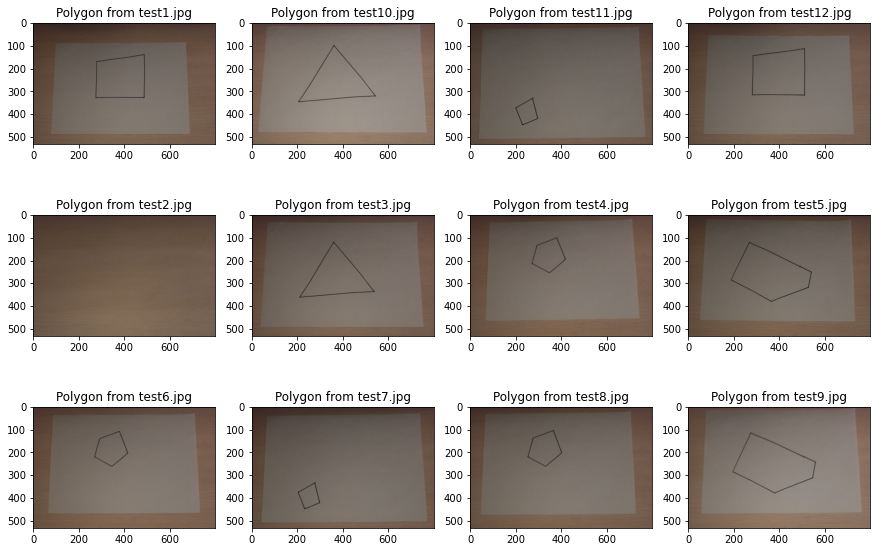

In [2]:
dataset = get_images('data/')
# константы для разбиения фотографий на две половины (используются фотографии размером 1065х800)
midline = 532
height = 1065
width = 800

fig_up, ax_up = plt.subplots(3, 4, figsize=(15, 10))

for i, (image, name) in enumerate(dataset):
    polygon = image[0:midline, 0:width]
    
    ax_up[i // 4][i % 4].set_title(f'Polygon from {name}')
    ax_up[i // 4][i % 4].imshow(cv2.cvtColor(polygon, cv2.COLOR_BGR2RGB))

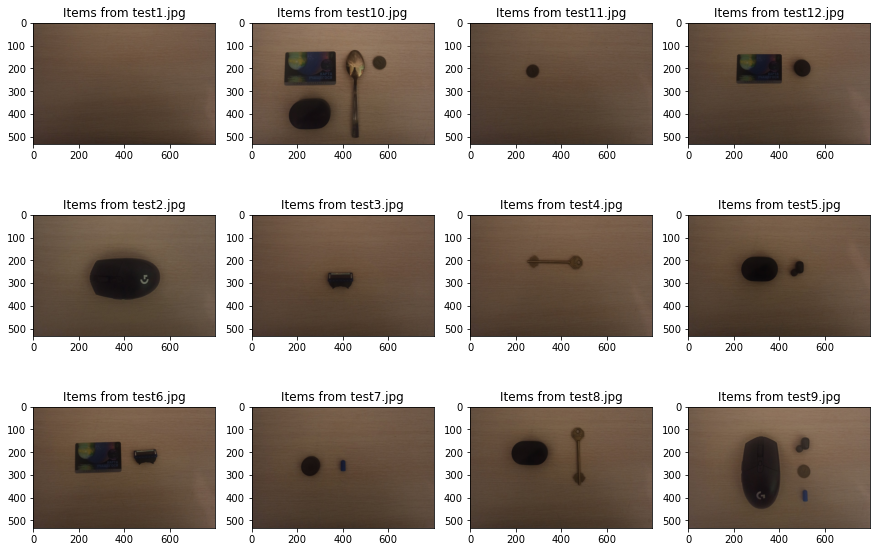

In [3]:
fig_down, ax_down = plt.subplots(3, 4, figsize=(15, 10))
for i, (image, name) in enumerate(dataset):
    items = image[midline:height, 0:width]
    
    ax_down[i // 4][i % 4].set_title(f'Items from {name}')
    ax_down[i // 4][i % 4].imshow(cv2.cvtColor(items, cv2.COLOR_BGR2RGB))

In [4]:
# списки для контуров, полученных из датасета
poly_contours_from_data = []
items_contours_from_data = []

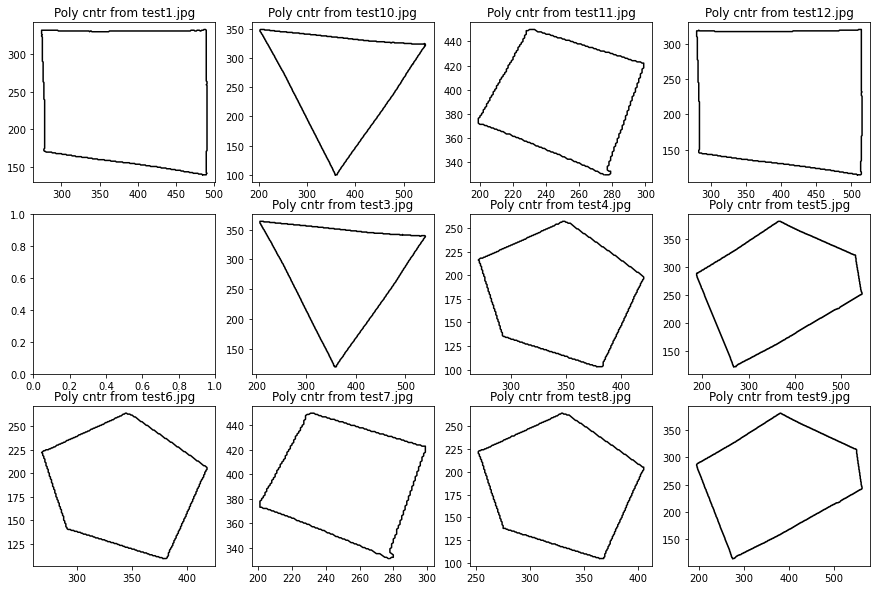

In [6]:
fig_poly, ax_poly = plt.subplots(3, 4, figsize=(15, 10))

for i, (image, name) in enumerate(dataset):
    polygon = image[0:midline, 0:width]
    contour = get_contour_polygon(polygon)
    poly_contours_from_data.append(contour)
    if len(contour) == 0:
        continue
    
    ax_poly[i // 4][i % 4].set_title(f'Poly cntr from {name}')
    ax_poly[i // 4][i % 4].plot(contour[:, 0][:, 0], contour[:, 0][:, 1], color='black')

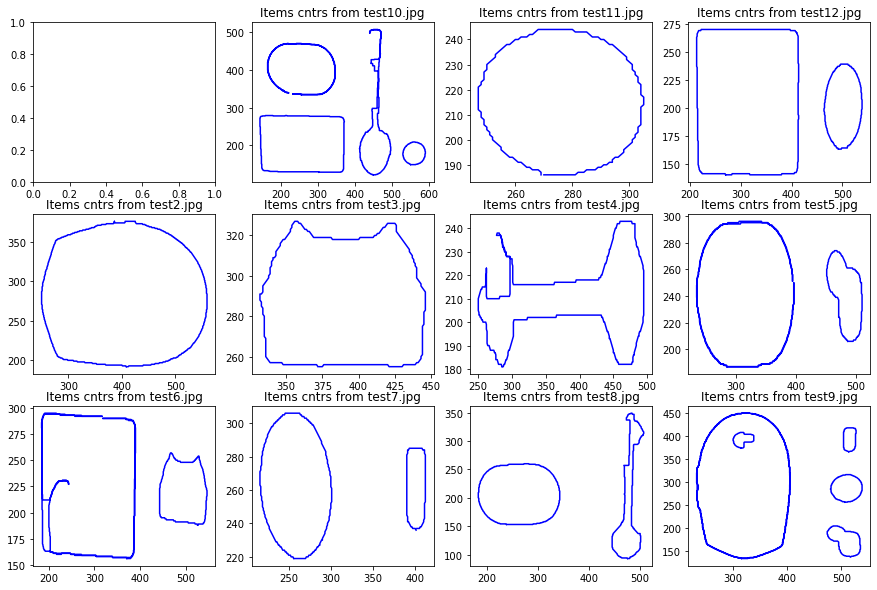

In [7]:
fig_items, ax_items = plt.subplots(3, 4, figsize=(15, 10))
for i, (image, name) in enumerate(dataset):
    items = image[midline:height, 0:width]
    contours = get_contours_items(items)
    items_contours_from_data.append(contours)
    if len(contours) == 0:
        continue
    
    ax_items[i // 4][i % 4].set_title(f'Items cntrs from {name}')
    for c in contours:
        ax_items[i // 4][i % 4].plot(c[:, 0][:, 0], c[:, 0][:, 1], color='blue')

Проверим наш датасет функцией can_fit, которая пока проверяет наличие контуров и условие суммы площадей контуров предметов (должна быть не больше площади самого прямоугольника) и выводит False, если условия не выполнены, и True в обратном случае


In [21]:
correct_output = 0
table = pd.read_csv('expected.csv')
table

,name,expected
0,1.jpg,0
1,10.jpg,0
2,11.jpg,1
3,12.jpg,1
4,2.jpg,0
5,3.jpg,1
6,4.jpg,0
7,5.jpg,1
8,6.jpg,0
9,7.jpg,1


Прогоняем датасет через функцию

In [22]:
func_answers = []
for i in range(len(dataset)):
    expected = table.loc[i, 'expected']
    result = can_fit(poly_contours_from_data[i], items_contours_from_data[i])
    correct_output += (result == expected)
    func_answers.append(int(result))

Итоговая таблица

In [23]:
table.join(pd.DataFrame(np.array(func_answers), columns=['real']))

,name,expected,real
0,1.jpg,0,0
1,10.jpg,0,0
2,11.jpg,1,1
3,12.jpg,1,0
4,2.jpg,0,0
5,3.jpg,1,0
6,4.jpg,0,1
7,5.jpg,1,1
8,6.jpg,0,1
9,7.jpg,1,1


И на данный момент наш примитивный алгоритм даёт следующий результат

In [24]:
correct_output / len(dataset)

0.6666666666666666

В следующем планируется добавить больше тестов, вероятно заменить проблемные айтемы и реализовать адекватный алгоритм. На данный момент кажется приоритетной идея стараться разместить по очереди каждый из предметов во многоугольнике - если упаковать его не получается никак, то работа программы прекращается сразу и другие предметы не проверяются. В ином случае, уменьшаем площадь исходного прямоугольника ровно на площадь упакованного предмета. Скорее всего потребуется находить выпуклые оболочки предметов для более удобной работы. 